# GRU Stock Price Prediction Model


## Reason for model change
In our project proposal, we initially decided to use the CNN model as one of our models. However, after receiving feedback that a CNN may not be ideal for time-series information, we decided to research other options, and use another RNN-based model, The GRU (greident recurrent unit) model. 

While both models take into account the relationships between different data points, the main issue with CNN’s is that they are designed to handle spatial patterns better, making them ideal for images, and less so for sequential data such as time-series data. GRU models process data in chronological order (sequential), which is critical for time series data. 
 

## Overview
This notebook implements a Long Short-Term Memory (LSTM) neural network for stock price prediction using **5 key features** that are easy to understand and explain to stakeholders.




In [1]:
# Step 0: Import Libraries

import os
import itertools
import math
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
plt.style.use("seaborn-v0_8")

In [2]:
# enable GPU is running the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
# Helper Functions for Feature Engineering and Sequence Creation

def calculate_features(df):
    """
    Calculate the 5 key features for stock prediction:
    1. Close - closing price
    2. Volume - trading volume
    3. MA20 - 20-day moving average
    4. Volatility - 20-day standard deviation of returns
    5. RSI - Relative Strength Index (14-day)
    """
    df = df.copy()
    
    # Feature 1: Close price (already in dataset)
    # Feature 2: Volume (already in dataset)
    
    # Feature 3: 20-day Moving Average
    df['MA20'] = df['Close'].rolling(window=20).mean()
    
    # Feature 4: Volatility (standard deviation of daily returns)
    df['Daily_Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
    
    # Feature 5: RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Drop the intermediate Daily_Return column (not needed as feature)
    df = df.drop('Daily_Return', axis=1)
    
    return df


def create_sequences_multivariate(data, feature_cols, target_col, n_past):
    """
    Create sequences for multivariate LSTM
    
    Args:
        data: DataFrame with all features
        feature_cols: list of column names to use as features
        target_col: name of target column to predict
        n_past: number of past time steps to use as input
    
    Returns:
        X: (num_samples, n_past, num_features)
        y: (num_samples,)
    """
    X, y = [], []
    
    feature_data = data[feature_cols].values
    target_data = data[target_col].values
    
    for i in range(n_past, len(data)):
        X.append(feature_data[i - n_past:i])
        y.append(target_data[i])
    
    return np.array(X), np.array(y)


In [4]:
# load data
# Paths relative to project root

# gets the metadata for all symbols
DATA_ROOT = "../../data/archive"
Symbols_path = os.path.join(DATA_ROOT, "symbols_valid_meta.csv")

tickers_df = pd.read_csv(Symbols_path)

print("Meta columns:", tickers_df.columns.tolist())
print("Number of symbols in meta:", len(tickers_df))

# Example: A
# May change how to pick the symbol to be done on function call 

target_ticker = "A"

# Find symbol row
row = tickers_df[tickers_df["Symbol"] == target_ticker]
if row.empty:
    raise ValueError(f"Symbol {target_ticker} not found in metadata.")

is_etf = (row["ETF"].iloc[0] == "Y")
asset_type = "etfs" if is_etf else "stocks"

print(f"Selected symbol: {target_ticker} | ETF? {is_etf} | Folder: {asset_type}")

Meta columns: ['Nasdaq Traded', 'Symbol', 'Security Name', 'Listing Exchange', 'Market Category', 'ETF', 'Round Lot Size', 'Test Issue', 'Financial Status', 'CQS Symbol', 'NASDAQ Symbol', 'NextShares']
Number of symbols in meta: 8049
Selected symbol: A | ETF? False | Folder: stocks


In [5]:
#Load data of selected ticker
data_path = os.path.join(DATA_ROOT, asset_type, f"{target_ticker}.csv")
stock_df = pd.read_csv(data_path)
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200


In [6]:
 # Make sure there is a date column named "Date"
if "Date" not in stock_df.columns:
    if "date" in stock_df.columns:
        stock_df = stock_df.rename(columns={"date": "Date"})
    else:
        raise KeyError("Could not find a 'Date' or 'date' column in the CSV.")

# Ensure we have a closing price column named "Close"
if "Close" not in stock_df.columns:
    # Some datasets use "Adj Close" or "close"
    if "Adj Close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"Adj Close": "Close"})
    elif "close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"close": "Close"})
    else:
        raise KeyError("Could not find a 'Close', 'Adj Close', or 'close' column.")

# Convert Date to datetime and sort chronologically
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values("Date").reset_index(drop=True)

print("Date range:", stock_df["Date"].min().date(), "to", stock_df["Date"].max().date())

# Optional: restrict the time window (you can adjust these)
start_date = datetime(2014, 1, 1)
end_date   = datetime(2020, 4, 1)  # e.g., up to April 2020 if using Kaggle archive

mask = (stock_df["Date"] >= start_date) & (stock_df["Date"] <= end_date)
stock_df = stock_df.loc[mask].reset_index(drop=True)


stock_df[["Date", "Close"]].head()

Date range: 1999-11-18 to 2020-04-01


,Date,Close
0,2014-01-02,40.207439
1,2014-01-03,40.715309
2,2014-01-06,40.515022
3,2014-01-07,41.094421
4,2014-01-08,41.766811


In [7]:
# Prepare Dataset with 5 Key Features

# Add the 4 calculated features (Close and Volume already exist)
stock_df = calculate_features(stock_df)

# Drop rows with NaN values (from rolling windows)
stock_df = stock_df.dropna().reset_index(drop=True)

print(f"Data shape after feature engineering: {stock_df.shape}")
print(f"Available columns: {stock_df.columns.tolist()}")

# Select the 5 features for the model
feature_columns = [
    'Close',      # Feature 1: Historical closing prices
    'Volume',     # Feature 2: Trading volume
    'MA20',       # Feature 3: 20-day moving average (trend)
    'Volatility', # Feature 4: Price volatility (risk)
    'RSI'         # Feature 5: Relative Strength Index (momentum)
]

target_column = 'Close'

print(f"\n✓ Using {len(feature_columns)} features for prediction:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i}. {feat}")

# Extract data for scaling
dates = stock_df["Date"].values
feature_data = stock_df[feature_columns].values
target_data = stock_df[target_column].values.reshape(-1, 1)

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features = feature_scaler.fit_transform(feature_data)
scaled_target = target_scaler.fit_transform(target_data)

# Chronological split: 80% train / 20% test
train_size = int(len(scaled_features) * 0.8)

train_features = scaled_features[:train_size]
train_target = scaled_target[:train_size]

test_features = scaled_features[train_size:]
test_target = scaled_target[train_size:]

print(f"\nTrain features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Number of past days to use for prediction
n_past = 60

# Create sequences directly from scaled data (no need to combine since Close is already in features)
train_df = pd.DataFrame(train_features, columns=feature_columns)
test_df = pd.DataFrame(test_features, columns=feature_columns)


# Validation split
val_start = int(len(train_df) * 0.8)
val_df = train_df.iloc[val_start:].reset_index(drop=True)
train_df = train_df.iloc[:val_start].reset_index(drop=True)

X_train, y_train = create_sequences_multivariate(train_df, feature_columns, target_column, n_past)
X_val, y_val = create_sequences_multivariate(val_df, feature_columns, target_column, n_past)
X_test, y_test = create_sequences_multivariate(test_df, feature_columns, target_column, n_past)

print(f"\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Features per timestep: {X_train.shape[2]}")


Data shape after feature engineering: (1553, 10)
Available columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA20', 'Volatility', 'RSI']

✓ Using 5 features for prediction:
  1. Close
  2. Volume
  3. MA20
  4. Volatility
  5. RSI

Train features shape: (1242, 5)
Test features shape: (311, 5)

X_train: (933, 60, 5), y_train: (933,)
X_val: (189, 60, 5), y_val: (189,)
X_test: (251, 60, 5), y_test: (251,)
Features per timestep: 5


In [8]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_val_tensor  = torch.from_numpy(X_val).float()
y_val_tensor  = torch.from_numpy(y_val).float()

X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)


In [9]:
class GRUModel(nn.Module):
    """
    GRU model for stock price prediction with tunable hyperparameters
    
    Architecture:
    - Input layer (receives multivariate time series)
    - 2 Bidirectional GRU layers with dropout
    - Fully connected output layer
    
    """
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2, bidirectional=True):
        """
        Args:
            input_size (int): Number of input features (5 in our case)
            hidden_size (int): Number of hidden units in each GRU layer
            num_layers (int): Number of stacked GRU layers
            dropout (float): Dropout probability (0.0 to 1.0)
            bidirectional (bool): If True, use bidirectional GRU
        """
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # GRU layers
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        # If bidirectional, hidden_size is doubled
        fc_input_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(fc_input_size, 1)
        
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)
        
        Returns:
            predictions: Tensor of shape (batch_size,)
        """
        # x shape: (batch_size, n_past, num_features)
        
        # Pass through GRU layers
        # gru_out shape: (batch_size, n_past, hidden_size * num_directions)
        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)
        gru_out, hidden = self.gru(x)
        
        # Take the output from the last time step
        # Shape: (batch_size, hidden_size * num_directions)
        last_output = gru_out[:, -1, :]
        
        # Apply dropout
        last_output = self.dropout(last_output)
        
        # Pass through fully connected layer
        # Shape: (batch_size, 1)
        prediction = self.fc(last_output)
        
        # Remove last dimension
        # Shape: (batch_size,)
        return prediction.squeeze(-1)

In [10]:
# train and evaluation functions

def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    
    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
    
    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss



def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
    
    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss

In [11]:
input_size = len(feature_columns)  # 5 features


# 2^5 = 32 combinations. We will limit the options to reduce total runs 

# define all hyoerapramters we want to tune 
hyperparams = {
    "hidden_size": [64, 128],
    "num_layers": [2, 3],
    "dropout": [0.2, 0.3],
    "bidirectional": [True, False],
    "learning_rate": [0.001, 0.0005],
}

# training constants 

num_epochs = 50

# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# optomizer will be defined inside the loop since learning rate is a hyperparameter



In [ ]:
def tune_hyperparameters(hyperparams, input_size, train_loader, test_loader, criterion, num_epochs, device):
    
    # Generate all combinations of hyperparameters
    keys, values = zip(*hyperparams.items())
    hyperparam_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    best_model = None
    best_val_loss = float('inf')
    best_hyperparams = None

    best_train_losses = []
    best_test_losses = []

    for i, params in enumerate(hyperparam_combinations):
        print(f"\n--- Hyperparameter Set {i+1}/{len(hyperparam_combinations)}: {params} ---")
        
        model = GRUModel(
            input_size=input_size,
            hidden_size=params["hidden_size"],
            num_layers=params["num_layers"],
            dropout=params["dropout"],
            bidirectional=params["bidirectional"]
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
        
        tmp_train_losses = []   
        tmp_test_losses = []

        for epoch in range(num_epochs):
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss = evaluate_model(model, val_loader, criterion, device)

            tmp_train_losses.append(train_loss)
            tmp_test_losses.append(val_loss)
            
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Check if this model is the best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_hyperparams = params
            best_train_losses = tmp_train_losses
            best_test_losses = tmp_test_losses
    
    print(f"\nBest Hyperparameters: {best_hyperparams} with Val Loss: {best_val_loss:.6f}")
    return best_model, best_hyperparams, best_train_losses, best_test_losses

In [13]:
# run hyperparameter tuning

best_model, best_hyperparams, best_train_losses, best_test_losses = tune_hyperparameters(
    hyperparams,
    input_size,
    train_loader,
    test_loader,
    criterion,
    num_epochs,
    device
)

torch.save(best_model.state_dict(), f"best_gru_model_{target_ticker}.pth")
print(f"Best model saved to best_gru_model_{target_ticker}.pth")


--- Hyperparameter Set 1/32: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'bidirectional': True, 'learning_rate': 0.001} ---
Epoch [1/50] - Train Loss: 0.036481, Val Loss: 0.005538
Epoch [10/50] - Train Loss: 0.001016, Val Loss: 0.001766
Epoch [20/50] - Train Loss: 0.000804, Val Loss: 0.001396
Epoch [30/50] - Train Loss: 0.000737, Val Loss: 0.001252
Epoch [40/50] - Train Loss: 0.000676, Val Loss: 0.001432
Epoch [50/50] - Train Loss: 0.000609, Val Loss: 0.001166

--- Hyperparameter Set 2/32: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'bidirectional': True, 'learning_rate': 0.0005} ---
Epoch [1/50] - Train Loss: 0.034260, Val Loss: 0.026217
Epoch [10/50] - Train Loss: 0.000926, Val Loss: 0.001683
Epoch [20/50] - Train Loss: 0.000799, Val Loss: 0.001765
Epoch [30/50] - Train Loss: 0.000759, Val Loss: 0.001351
Epoch [40/50] - Train Loss: 0.000628, Val Loss: 0.001285
Epoch [50/50] - Train Loss: 0.000554, Val Loss: 0.001413

--- Hyperparameter Set 3/32: {'hidden_size': 64,

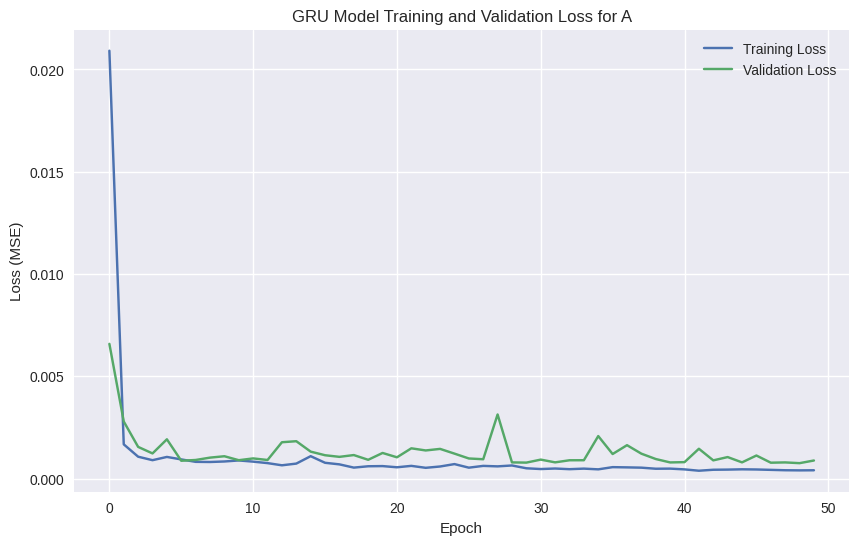

In [14]:
# plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title(f'GRU Model Training and Validation Loss for {target_ticker}')
plt.legend()
plt.show()

In [15]:
# Load best model and evaluate - CORRECTED

# Step 1: Recreate the model architecture with best hyperparameters
model = GRUModel(
    input_size=input_size,
    hidden_size=best_hyperparams["hidden_size"],
    num_layers=best_hyperparams["num_layers"],
    dropout=best_hyperparams["dropout"],
    bidirectional=best_hyperparams["bidirectional"]
).to(device)

# Step 2: Load the saved weights into the model
model.load_state_dict(torch.load(f"best_gru_model_{target_ticker}.pth"))

# Step 3: Set to evaluation mode
model.eval()

# Step 4: Make predictions
predictions = []
actual_values = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().numpy())
        actual_values.extend(y_batch.cpu().numpy())

# Step 5: Inverse transform predictions and true values
predictions = np.array(predictions).reshape(-1, 1)
actual_values = np.array(actual_values).reshape(-1, 1)

predictions_rescaled = target_scaler.inverse_transform(predictions)
y_test_rescaled = target_scaler.inverse_transform(actual_values)

# Step 6: Calculate metrics
rmse = math.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mae = np.mean(np.abs(y_test_rescaled - predictions_rescaled))
mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

print(f"\n{'='*60}")
print(f"Best Model Performance on {target_ticker}")
print(f"{'='*60}")
print(f"Hyperparameters: {best_hyperparams}")
print(f"{'='*60}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"{'='*60}\n")


Best Model Performance on A
Hyperparameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'bidirectional': True, 'learning_rate': 0.001}
Test RMSE: 3.2255
Test MAE:  2.7171
Test MAPE: 3.49%

